In [1]:
from dataclasses import dataclass, field
from vi import Agent, Config, Simulation, Vector2, HeadlessSimulation
import pygame as pg
import os
import numpy as np
import random
from multiprocessing import Pool
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pygame 2.6.1 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)
frame_count = 0

def save_frame(screen):
    global frame_count
    pg.image.save(screen, os.path.join(frame_dir, f"frame_{frame_count:05d}.png"))
    frame_count += 1

In [4]:
class RecordingSimulation(Simulation):
    def __init__(self, config):
        super().__init__(config)
        self.frame_count = 0
        os.makedirs("frames", exist_ok=True)

    def after_update(self) -> None:
        # Draw everything to the screen
        self._all.draw(self._screen)

        if self.config.visualise_chunks:
            self.__visualise_chunks()

        # Save current frame as an image
        pg.image.save(self._screen, f"frames/frame_{self.frame_count:05d}.png")

        # Update the screen with the new image
        pg.display.flip()

        self._clock.tick(self.config.fps_limit)

        current_fps = self._clock.get_fps()
        if current_fps > 0:
            self._metrics.fps._push(current_fps)

            if self.config.print_fps:
                print(f"FPS: {current_fps:.1f}")  # noqa: T201

        # Increment a frame counter (you may need to initialize it somewhere)
        self.frame_count += 1

        #update pheromone grid
        self.config.pheromone_grid_decay()


In [5]:
@dataclass
class AggregationConfig(Config):
    pheromone_decay: float = 0.01
    cell_size: int = 50
    pheromone_grid: np.ndarray = field(default_factory=lambda: np.zeros((15, 15)))
    attraction_strength: float = 0.5
    random_movement: float = 0.05  
    min_separation_distance: float = 10.0

    def update_pheromone_grid(self, x, y):
        grid_x = int(x // self.cell_size)
        grid_y = int(y // self.cell_size)
        if 0 <= grid_x < len(self.pheromone_grid) and 0 <= grid_y < len(self.pheromone_grid[0]):
            self.pheromone_grid[grid_x][grid_y] += 0.01
    
    def pheromone_grid_decay(self):
        self.pheromone_grid = np.where(self.pheromone_grid < 0.001, 0, self.pheromone_grid - self.pheromone_decay)
    
    def get_pheromone_gradient(self, x, y):
        grid_x = int(x // self.cell_size)
        grid_y = int(y // self.cell_size)
        
        neighbors = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = grid_x + dx, grid_y + dy
                if 0 <= nx < self.pheromone_grid.shape[0] and 0 <= ny < self.pheromone_grid.shape[1]:
                    neighbors.append((dx, dy, self.pheromone_grid[nx, ny]))
        
        if not neighbors:
            return Vector2(0, 0)
        
        max_dx, max_dy, max_val = max(neighbors, key=lambda x: x[2])
        return Vector2(max_dx, max_dy) * max_val


class AggregationAgent(Agent):

    def on_spawn(self):
        if random.random() < 0.1:   #10% chance to be a scout
            self.is_scout = True
            self._image_index = 1
        else:
            self.is_scout = False
        self.best_cluster = None
        self.best_cluster_found = False
        self.best_cluster_pheromone = 0 
        self.scout_new_cluster_cooldown = 200

        self.change_direction_cooldown = random.randint(50, 200)
        return super().on_spawn()
    
    def find_current_cluster_pheromone(self):
        grid_x = int(self.pos[0] // self.config.cell_size)
        grid_y = int(self.pos[1] // self.config.cell_size)
        if 0 <= grid_x < self.config.pheromone_grid.shape[0] and 0 <= grid_y < self.config.pheromone_grid.shape[1]:
            return self.config.pheromone_grid[grid_x, grid_y]
        return 0
    
    def find_current_cluster(self):
        grid_x = int(self.pos[0] // self.config.cell_size)
        grid_y = int(self.pos[1] // self.config.cell_size)
        return (grid_x, grid_y)
    
    def scout_behavior(self):
        pheromone_level = self.find_current_cluster_pheromone()
        if pheromone_level > self.best_cluster_pheromone:
            self.best_cluster_pheromone = pheromone_level
            self.best_cluster = (int(self.pos[0] // self.config.cell_size),
                                    int(self.pos[1] // self.config.cell_size))
        #randomly explore nearby areas
        if self.change_direction_cooldown == 0:
            pheromone_gradient = self.config.get_pheromone_gradient(self.pos[0], self.pos[1])
            random_dir = Vector2(random.uniform(-1, 1), random.uniform(-1, 1))

            if random_dir.length() > 0:
                random_dir = random_dir.normalize()

            self.change_direction_cooldown = random.randint(50, 150)
            self.move = random_dir * self.config.movement_speed
            self.pos += self.move
        else:
            self.pos += self.move
            self.change_direction_cooldown -= 1

        neighbors = list(self.in_proximity_accuracy())
        if all(neighbor.best_cluster ==self.best_cluster for neighbor, _ in neighbors):
            self.scout_new_cluster_cooldown -= 1
        else:
            self.scout_new_cluster_cooldown = 200

        if self.scout_new_cluster_cooldown <= 0:
            self.is_scout = False

    def change_position(self):
        self.there_is_no_escape()
        
        self.config.update_pheromone_grid(self.pos[0], self.pos[1])

        #if agent is a scout, it will explore
        if self.is_scout:
            self.scout_behavior()
            return
        
        neighbors = list(self.in_proximity_accuracy())

        #communicate with neighbors to find the best cluster
        for neighbor, _ in neighbors:
            if neighbor.best_cluster_pheromone > self.best_cluster_pheromone and neighbor.best_cluster != self.best_cluster:
                self.best_cluster_pheromone = neighbor.best_cluster_pheromone
                self.best_cluster = neighbor.best_cluster
                self.best_cluster_found = False

        if self.best_cluster_found:
            repulsion = Vector2(0, 0)
            count = 0
            for neighbor, _ in neighbors:
                offset = self.pos - neighbor.pos
                dist = offset.length()
                if 0 < dist < self.config.min_separation_distance:
                    repulsion += offset.normalize() * (self.config.min_separation_distance - dist) / dist
                    count += 1
            if count > 0:
                repulsion /= count
                repulsion = repulsion.normalize() * self.config.movement_speed
                self.pos += repulsion
            
            if len(neighbors) < 5:
                self.best_cluster_found = False
                self.best_cluster = None
            return
            

        #if agent is already in the best clusterm then it will not move
        if self.find_current_cluster() == self.best_cluster:
            self.best_cluster_found = True
            self.best_cluster_pheromone = self.find_current_cluster_pheromone()
            return

        if self.best_cluster is not None:
            target_x = self.best_cluster[0] * self.config.cell_size + self.config.cell_size // 2
            target_y = self.best_cluster[1] * self.config.cell_size + self.config.cell_size // 2
            target_pos = Vector2(target_x, target_y)

            direction = (target_pos - self.pos).normalize() if (target_pos - self.pos).length() > 0 else Vector2(0, 0)

            if direction.length() > 0:
                direction = direction.normalize()
                self.move = direction * self.config.movement_speed
                self.pos += self.move
        else:
            # pheromone_gradient = self.config.get_pheromone_gradient(self.pos[0], self.pos[1])
            # direction = pheromone_gradient * self.config.attraction_strength
            # if direction.length() > 0:
            #     direction = direction.normalize()
            #     self.move = direction * self.config.movement_speed
            #     self.pos += self.move
            # else:
            if self.change_direction_cooldown == 0:
                random_dir = Vector2(random.uniform(-1, 1), random.uniform(-1, 1))
                if random_dir.length() > 0:
                    random_dir = random_dir.normalize()
                self.change_direction_cooldown = random.randint(50, 150)
                self.move = random_dir * self.config.movement_speed
                self.pos += self.move
            else:
                self.pos += self.move
                self.change_direction_cooldown -= 1

In [6]:
(
    RecordingSimulation(
        AggregationConfig(image_rotation = True, movement_speed = 5.0, radius = 50, seed = 777, duration = 3000, fps_limit = 60)
    )
    .batch_spawn_agents(100, AggregationAgent, images=["images/tarakan.png", "images/tarakan_scout.png"])
    .run()
)

KeyboardInterrupt: 

In [14]:
class HeadlessSimulationRefined(HeadlessSimulation):
   def __init__(self, config):
      super().__init__(config)
      self.frame_count = 0
      self.num_clusters_per_frames = []

   def after_update(self) -> None:
      # Increment a frame counter (you may need to initialize it somewhere)
      self.frame_count += 1
      if self.frame_count % 50 == 0:
         clusters = set()
         for agent in self._all:
            clusters.add(agent.best_cluster)
         self.num_clusters_per_frames.append(len(clusters))


      #update pheromone grid
      self.config.pheromone_grid_decay()
   def run(self):
        """Run the simulation until it's ended by closing the window or when the `vi.config.Schema.duration` has elapsed."""
        self._running = True

        while self._running:
            self.tick()

        return self.num_clusters_per_frames

In [15]:
def run_simulation(config: Config) -> pl.DataFrame:
    return (
        HeadlessSimulationRefined(config)
        .batch_spawn_agents(100, AggregationAgent, images=["images/tarakan.png", "images/tarakan_scout.png"])
        .run()
    )

In [16]:
all_results = []
for run in range(30):
    cluster_counts = run_simulation(AggregationConfig(image_rotation = True, movement_speed = 5.0, radius = 50, duration = 3000, fps_limit = 0)) 
    for i, count in enumerate(cluster_counts):
        frame = (i + 1) * 50
        all_results.append({"run": run + 1, "frame": frame, "clusters": count})
    print(f"{(run + 1) * 100 // 30} %")
df = pl.DataFrame(all_results)
df.write_csv("simulation_results_no_pheromone_gradient.csv")
    

3 %
6 %
10 %
13 %
16 %
20 %
23 %
26 %
30 %
33 %
36 %
40 %
43 %
46 %
50 %
53 %
56 %
60 %
63 %
66 %
70 %
73 %
76 %
80 %
83 %
86 %
90 %
93 %
96 %
100 %


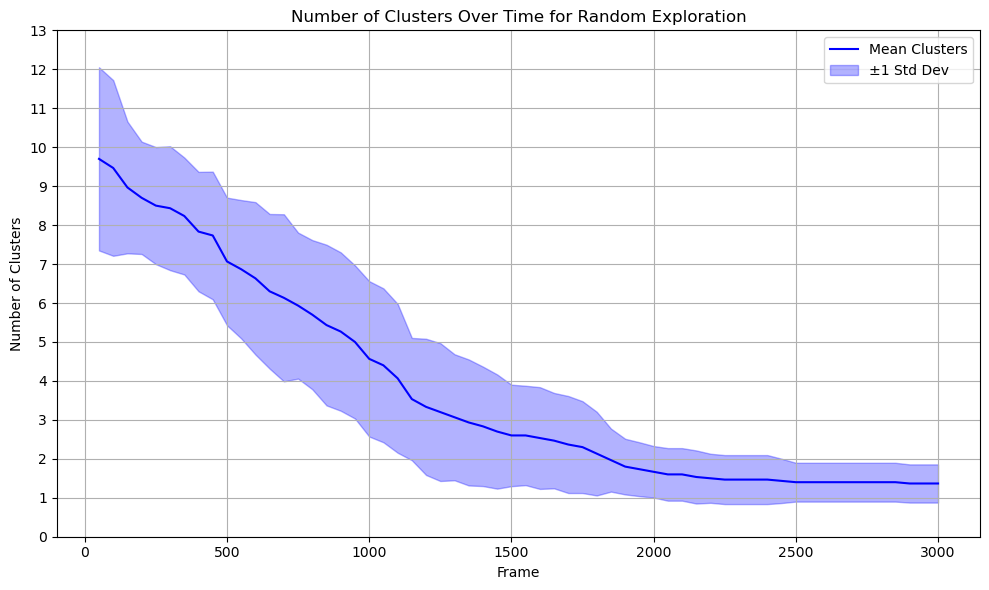

In [2]:
df = pl.read_csv("simulation_results_no_pheromone_gradient.csv")

# Group and aggregate
agg_df = (
    df.group_by("frame")
    .agg([
        pl.col("clusters").mean().alias("mean_clusters"),
        pl.col("clusters").std().alias("std_clusters")
    ])
    .sort("frame")
)

# Convert to pandas
pdf = agg_df.to_pandas()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=pdf, x="frame", y="mean_clusters", label="Mean Clusters", color="blue")
plt.fill_between(
    pdf["frame"],
    pdf["mean_clusters"] - pdf["std_clusters"],
    pdf["mean_clusters"] + pdf["std_clusters"],
    alpha=0.3,
    color="blue",
    label="±1 Std Dev"
)

# Ensure every number is shown on y-axis
y_min = int((pdf["mean_clusters"] - pdf["std_clusters"]).min())
y_max = int((pdf["mean_clusters"] + pdf["std_clusters"]).max()) + 1
plt.yticks(np.arange(y_min, y_max + 1, 1))

plt.title("Number of Clusters Over Time for Random Exploration")
plt.xlabel("Frame")
plt.ylabel("Number of Clusters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()